# Skin Lesion Classification with EfficientNet (Transfer Learning)

This Colab notebook trains an EfficientNet-based classifier using transfer learning.

Data assumptions:
- CSV: `/content/drive/MyDrive/mini_proj_data/proj_metadata.csv`
- Images directory: `/content/drive/MyDrive/mini_proj_data/Processed_data/` containing `.jpg` files.

CSV columns: `lesion_id, image_id, dx, dx_type, age, sex, localization, image_path`
- `dx` is the target label.
- If `image_path` is empty, we will form it as `Processed_data/{image_id}.jpg`.

Workflow:
1. Mount Google Drive and set paths
2. Load and clean metadata
3. Train/validation split (stratified by `dx`)
4. Build tf.data pipelines with on-the-fly augmentations
5. Train EfficientNetV2/ EfficientNetB0 (frozen base), then fine-tune
6. Evaluate and visualize results

You can tweak image size, batch size, and model variant as needed.

In [3]:
# Environment and setup
# - Mount Google Drive
# - Define base paths and hyperparams
# - Check TensorFlow version
# - Create output directories

import os, sys, json, math, random
from datetime import datetime

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/mini_proj_data'
CSV_PATH = os.path.join(BASE_DIR, 'proj_metadata.csv')
IMG_DIR = os.path.join(BASE_DIR, 'Processed_data')
OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
CKPT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints')
LOGS_DIR = os.path.join(OUTPUT_DIR, 'logs')
MODEL_DIR = os.path.join(OUTPUT_DIR, 'models')

for d in [OUTPUT_DIR, CKPT_DIR, LOGS_DIR, MODEL_DIR]:
    os.makedirs(d, exist_ok=True)

# Hyperparameters
IMG_SIZE = (224, 224)  # can use (240, 260, 300) for larger EfficientNet variants
BATCH_SIZE = 32
INIT_LR = 3e-4
FINE_TUNE_LR = 1e-5
EPOCHS_FROZEN = 10
EPOCHS_FINETUNE = 10
VAL_SPLIT = 0.2
SEED = 42

import tensorflow as tf
print('TensorFlow version:', tf.__version__)
try:
    import tensorflow_addons as tfa
    print('TensorFlow Addons version:', tfa.__version__)
except Exception as e:
    print('TensorFlow Addons not available:', e)

# Colab GPU optimizations: mixed precision + XLA
ON_GPU = len(tf.config.list_physical_devices('GPU')) > 0
if ON_GPU:
    try:
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print('Mixed precision enabled:', tf.keras.mixed_precision.global_policy())
    except Exception as e:
        print('Mixed precision not enabled:', e)
    try:
        tf.config.optimizer.set_jit(True)
        print('XLA JIT enabled')
    except Exception as e:
        print('XLA not enabled:', e)
else:
    print('GPU not detected; skipping mixed precision and XLA')

# Set seeds for reproducibility
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
tf.random.set_seed(SEED)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow version: 2.19.0
TensorFlow Addons not available: No module named 'tensorflow_addons'
Mixed precision enabled: <DTypePolicy "mixed_float16">
XLA JIT enabled


In [5]:
# Data loading and preprocessing
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Read metadata
meta = pd.read_csv(CSV_PATH)
print('Rows in CSV:', len(meta))
print('Columns:', list(meta.columns))

# Basic cleaning
# Drop rows without target label `dx`
meta = meta.dropna(subset=['dx']).copy()
# Resolve image path: use existing `image_path` if provided, else fallback to Processed_data/{image_id}.jpg

def resolve_path(row):
    p = row.get('image_path', None)
    if isinstance(p, str) and len(p.strip()) > 0:
        # If path is relative, resolve against BASE_DIR
        p = p.strip()
        if not os.path.isabs(p):
            p = os.path.join(BASE_DIR, p)
        return p
    image_id = str(row['image_id']).strip()
    return os.path.join(IMG_DIR, f"{image_id}.jpg")

meta['resolved_path'] = meta.apply(resolve_path, axis=1)
# Filter only paths that exist
exists_mask = meta['resolved_path'].apply(lambda p: os.path.isfile(p))
missing = (~exists_mask).sum()
if missing:
    print(f"Warning: {missing} images not found; dropping those rows")
meta = meta[exists_mask].reset_index(drop=True)

# Encode labels
labels = meta['dx'].astype(str)
classes = sorted(labels.unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}
meta['label'] = labels.map(class_to_idx)
num_classes = len(classes)
print('Classes:', classes)
print('Num classes:', num_classes)

# Optional: stratify by `lesion_id` to avoid leakage between train/val
# If lesion_id exists, group by it. Otherwise, simple stratified split on labels.
if 'lesion_id' in meta.columns and meta['lesion_id'].notna().any():
    print('Using group-aware stratified split by lesion_id')
    groups = meta['lesion_id'].astype(str)
    sgkf = StratifiedGroupKFold(n_splits=int(1/VAL_SPLIT), shuffle=True, random_state=SEED)
    # Take first split as train/val
    y = meta['label'].values
    for tr_idx, va_idx in sgkf.split(meta, y, groups):
        train_df = meta.iloc[tr_idx].reset_index(drop=True)
        val_df = meta.iloc[va_idx].reset_index(drop=True)
        break
else:
    print('Using simple stratified train/val split')
    train_df, val_df = train_test_split(
        meta,
        test_size=VAL_SPLIT,
        stratify=meta['label'],
        random_state=SEED,
    )
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)

print('Train size:', len(train_df), 'Val size:', len(val_df))

# Compute class weights to handle imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_df['label'].values
)
class_weights = {int(i): float(w) for i, w in enumerate(class_weights)}
print('Class weights:', class_weights)

# Save label maps for later use
with open(os.path.join(OUTPUT_DIR, 'label_map.json'), 'w') as f:
    json.dump({'class_to_idx': class_to_idx, 'idx_to_class': idx_to_class}, f, indent=2)


Rows in CSV: 10015
Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization', 'image_path']
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Num classes: 7
Using group-aware stratified split by lesion_id
Train size: 8001 Val size: 2014
Class weights: {0: 4.413127413127413, 1: 2.760869565217391, 2: 1.278523489932886, 3: 12.290322580645162, 4: 1.2828282828282829, 5: 0.21396480718831898, 6: 10.583333333333334}


In [6]:
# tf.data input pipeline with augmentations
AUTO = tf.data.AUTOTUNE

@tf.function
def decode_and_resize(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE)
    return img

@tf.function
def augment(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img

@tf.function
def normalize_for_xception(img):
    # Scale to [-1, 1] as expected by Xception
    return img * 2.0 - 1.0

@tf.function
def pack(img, label):
    return img, tf.cast(label, tf.int32)


def make_ds(df, training=False, batch_size=BATCH_SIZE):
    paths = df['resolved_path'].values
    labels = df['label'].values
    options = tf.data.Options()
    if training:
        options.experimental_deterministic = False
    base = tf.data.Dataset.from_tensor_slices((paths, labels)).with_options(options)
    # Interleave files to avoid single-file stalls
    base = base.interleave(
        lambda p, y: tf.data.Dataset.from_tensors((p, y)),
        cycle_length=8,
        num_parallel_calls=AUTO,
        deterministic=not training
    )
    if training:
        base = base.shuffle(len(df), seed=SEED, reshuffle_each_iteration=True)
    ds = base.map(lambda p, y: (decode_and_resize(p), y), num_parallel_calls=AUTO)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    ds = ds.cache()  # cache decoded+resized images
    if training:
        ds = ds.map(lambda x, y: (augment(x), y), num_parallel_calls=AUTO)
    ds = ds.map(lambda x, y: (normalize_for_xception(x), y), num_parallel_calls=AUTO)
    ds = ds.map(pack, num_parallel_calls=AUTO)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(AUTO)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds = make_ds(val_df, training=False)

for batch in train_ds.take(1):
    x, y = batch
    print('Batch shape:', x.shape, y.shape)


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Batch shape: (32, 224, 224, 3) (32,)


In [7]:
# Build Xception transfer learning model
from tensorflow.keras import layers, models
from tensorflow.keras.applications import xception
inputs = layers.Input(shape=(*IMG_SIZE, 3))

# We normalize to [-1, 1] in the input pipeline, so no preprocessing layer here.
base = xception.Xception(include_top=False, weights='imagenet', input_tensor=inputs, pooling=None)
base.trainable = False

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=False,
    steps_per_execution=1
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,875,823 (79.63 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [8]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

run_id = datetime.now().strftime('%Y%m%d-%H%M%S')
ckpt_path = os.path.join(CKPT_DIR, f'best_{run_id}.keras')
log_dir = os.path.join(LOGS_DIR, run_id)

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint(ckpt_path, monitor='val_accuracy', save_best_only=True, save_weights_only=False),
    TensorBoard(log_dir=log_dir)
]

ckpt_path, log_dir

('/content/drive/MyDrive/mini_proj_data/outputs/checkpoints/best_20250913-072747.keras',
 '/content/drive/MyDrive/mini_proj_data/outputs/logs/20250913-072747')

In [9]:
# Train (frozen base)
history_frozen = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FROZEN,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Fine-tune: unfreeze some top layers
fine_tune_at = max(0, int(len(model.layers) * 0.75))
for layer in base.layers[fine_tune_at:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=False,
    steps_per_execution=1
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Save final model
final_model_path = os.path.join(MODEL_DIR, f'xception_{IMG_SIZE[0]}_{run_id}.keras')
model.save(final_model_path)
print('Saved model to:', final_model_path)


Epoch 1/10
    251/Unknown 133s 354ms/step - accuracy: 0.2725 - loss: 1.9611

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


251/251 ━━━━━━━━━━━━━━━━━━━━ 190s 582ms/step - accuracy: 0.2729 - loss: 1.9605 - val_accuracy: 0.5065 - val_loss: 1.5256 - learning_rate: 3.0000e-04
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 65s 260ms/step - accuracy: 0.5011 - loss: 1.4870 - val_accuracy: 0.5223 - val_loss: 1.4288 - learning_rate: 3.0000e-04
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - accuracy: 0.5253 - loss: 1.3383 - val_accuracy: 0.5551 - val_loss: 1.3250 - learning_rate: 3.0000e-04
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.5559 - loss: 1.2413 - val_accuracy: 0.5735 - val_loss: 1.2655 - learning_rate: 3.0000e-04
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.5744 - loss: 1.1774 - val_accuracy: 0.5849 - val_loss: 1.2213 - learning_rate: 3.0000e-04
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.5777 - loss: 1.1415 - val_accuracy: 0.5715 - val_loss: 1.2508 - learning_rate: 3.0000e-04
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accu

Validation metrics (loss, acc): [0.8076314926147461, 0.7179741859436035]

Classification report:
              precision    recall  f1-score   support

       akiec       0.35      0.68      0.46        68
         bcc       0.51      0.60      0.55       100
         bkl       0.45      0.49      0.47       205
          df       0.18      0.23      0.20        22
         mel       0.38      0.50      0.43       222
          nv       0.93      0.81      0.86      1363
        vasc       0.70      0.62      0.66        34

    accuracy                           0.72      2014
   macro avg       0.50      0.56      0.52      2014
weighted avg       0.77      0.72      0.74      2014



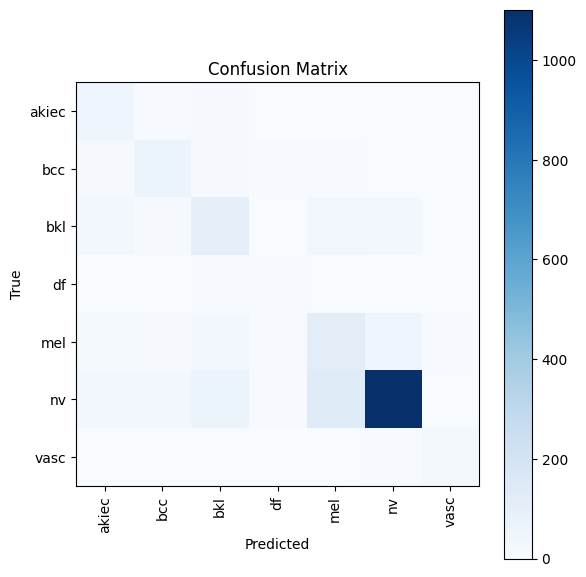

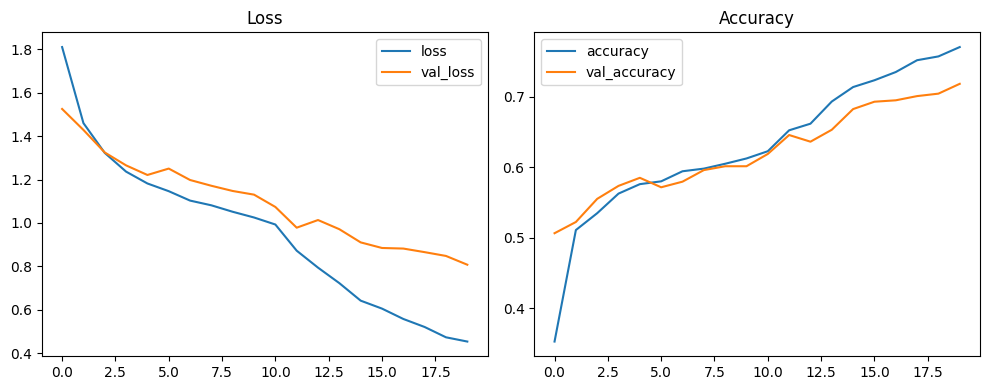

In [10]:
# Evaluation and visualization
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

val_metrics = model.evaluate(val_ds, verbose=0)
print('Validation metrics (loss, acc):', val_metrics)

# Predictions
all_labels = []
all_preds = []
for x, y in val_ds:
    preds = model.predict(x, verbose=0)
    all_preds.append(np.argmax(preds, axis=1))
    all_labels.append(y.numpy())

y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

print('\nClassification report:')
print(classification_report(y_true, y_pred, target_names=[idx_to_class[i] for i in range(num_classes)]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.xticks(ticks=range(num_classes), labels=[idx_to_class[i] for i in range(num_classes)], rotation=90)
plt.yticks(ticks=range(num_classes), labels=[idx_to_class[i] for i in range(num_classes)])
plt.tight_layout()
plt.show()

# Plot training curves
histories = []
if 'history_frozen' in globals():
    histories.append(history_frozen)
if 'history_ft' in globals():
    histories.append(history_ft)

history = { 'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [] }
for h in histories:
    for k in history.keys():
        history[k].extend(h.history.get(k, []))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.legend(); plt.title('Accuracy')
plt.tight_layout();
plt.show()
